<a href="https://colab.research.google.com/github/lisni946/Word2Vec_hellenistic_greek/blob/master/Greek_Word2Vec_Model_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation of Libraries and Importing Libraries

In [0]:
!pip install -q tf-nightly
!pip install --upgrade tensorflow

In [0]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [0]:
# !pip install google.colab

Load Text data 

In [0]:
#import google.colab
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
datatxt=tf.data.TextLineDataset('/Users/christinaoaks/Desktop/Nick/output.txt')  #(drive/My Drive/output.txt')

In [3]:
print(datatxt)

<TextLineDatasetV2 shapes: (), types: tf.string>


In [0]:
BUFFER_SIZE=50000
BATCH_SIZE=64
TAKE_SIZE=5000

In [0]:
def labeler(example,index):
  return example,tf.cast(index,tf.int64)

In [0]:
datatxt_processed=datatxt.map(lambda ex:labeler(ex,0))

Encode text lines as numbers

In [0]:
tokenizer=tfds.features.text.Tokenizer()
vocabulary_set=set()
for text_tensor, _ in datatxt_processed:
  some_tokens=tokenizer.tokenize(text_tensor.numpy())
  vocabulary_set.update(some_tokens)

In [8]:
vocab_size=len(vocabulary_set)
vocab_size

92377

In [0]:
encoder=tfds.features.text.TokenTextEncoder(vocabulary_set)
def encode(text_tensor,label):
  encoded_text=encoder.encode(text_tensor.numpy())
  return encoded_text, label

  
def encode_map_fn(text,label):
  encoded_text,label=tf.py_function(encode,
                                    inp=[text,label],
                                    Tout=(tf.int64,tf.int64))
  encoded_text.set_shape([None])
  label.set_shape([])

  return encoded_text, label

In [0]:
datatxt_processed=datatxt_processed.shuffle(BUFFER_SIZE,reshuffle_each_iteration=False)
encoded_data=datatxt_processed.map(encode_map_fn)

Split the dataset into test and train batches

In [0]:
train_data=encoded_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
train_data=train_data.padded_batch(BATCH_SIZE,padded_shapes=([None],[]))

test_data=encoded_data.take(TAKE_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE,padded_shapes=([None],[]))

In [0]:
train_data = encoded_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE, padded_shapes=([None],[]))

test_data = encoded_data.take(TAKE_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE, padded_shapes=([None],[]))

In [0]:
vocab_size += 1

Create a keras model

In [0]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,64))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dense(1))  

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history=model.fit(train_data, epochs=100, validation_data=test_data)

Epoch 1/100
4818/4818 [==============================] - 599s 124ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 3.1025e-09 - val_accuracy: 1.0000
Epoch 2/100
4818/4818 [==============================] - 599s 124ms/step - loss: 1.8276e-09 - accuracy: 1.0000 - val_loss: 8.3906e-10 - val_accuracy: 1.0000
Epoch 3/100
4818/4818 [==============================] - 577s 120ms/step - loss: 4.2099e-10 - accuracy: 1.0000 - val_loss: 1.8171e-10 - val_accuracy: 1.0000
Epoch 4/100
4818/4818 [==============================] - 2076s 431ms/step - loss: 9.8908e-11 - accuracy: 1.0000 - val_loss: 4.9413e-11 - val_accuracy: 1.0000
Epoch 5/100
4818/4818 [==============================] - 632s 131ms/step - loss: 2.9685e-11 - accuracy: 1.0000 - val_loss: 1.7441e-11 - val_accuracy: 1.0000
Epoch 6/100
4818/4818 [==============================] - 628s 130ms/step - loss: 1.2162e-11 - accuracy: 1.0000 - val_loss: 8.7697e-12 - val_accuracy: 1.0000
Epoch 7/100
4818/4818 [==============================] - 630s

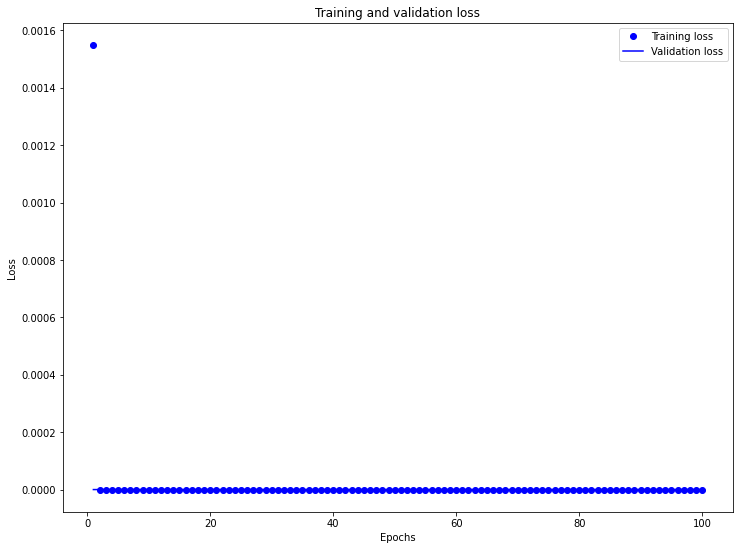

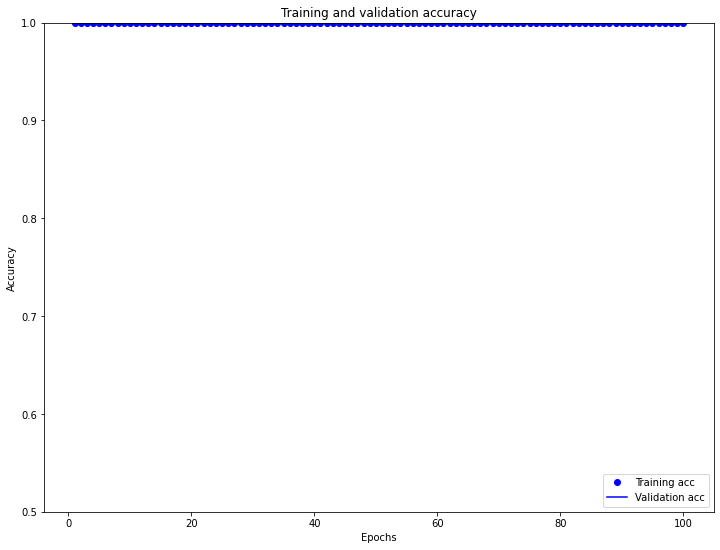

In [22]:
import matplotlib
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()



In [23]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(92378, 64)


In [0]:
pip install matplotlib

In [0]:
import io


out_v = io.open('vecs2.tsv', 'w', encoding='utf-8')
out_m = io.open('meta2.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.tokens):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

<MapDataset shapes: (None,), types: tf.string>

In [0]:
##
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')
##